Found 226 images belonging to 14 classes.
Found 22 images belonging to 14 classes.
Found 22 images belonging to 14 classes.
Epoch 1/30
8/8 [==============================] - 34s 3s/step - loss: 16.0697 - accuracy: 0.3761 - val_loss: 15.5449 - val_accuracy: 0.3636 - lr: 5.0000e-04
Epoch 2/30
8/8 [==============================] - 18s 2s/step - loss: 14.2396 - accuracy: 0.5398 - val_loss: 14.3675 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 3/30
8/8 [==============================] - 18s 2s/step - loss: 12.8299 - accuracy: 0.6549 - val_loss: 12.8973 - val_accuracy: 0.5455 - lr: 5.0000e-04
Epoch 4/30
8/8 [==============================] - 18s 2s/step - loss: 11.6904 - accuracy: 0.7788 - val_loss: 11.5698 - val_accuracy: 0.6818 - lr: 5.0000e-04
Epoch 5/30
8/8 [==============================] - 17s 2s/step - loss: 10.6913 - accuracy: 0.8230 - val_loss: 10.5588 - val_accuracy: 0.7273 - lr: 5.0000e-04
Epoch 6/30
8/8 [==============================] - 17s 2s/step - loss: 9.7349 - accuracy: 0.

c:\users\abubakar\disease-detect\scalpdetectai\env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


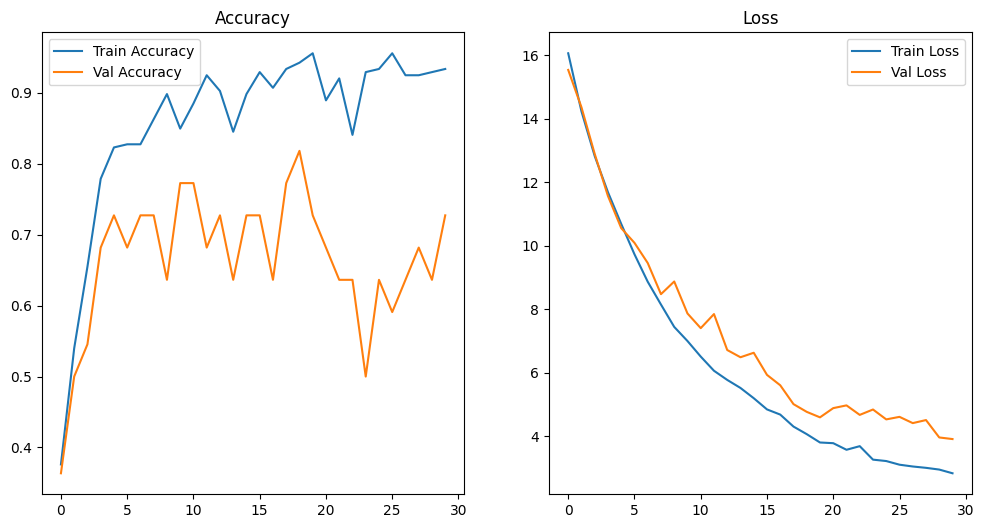

1/1 [==============================] - 1s 1s/step
Classification Report:
                        precision    recall  f1-score   support

       acne-keloidalis       0.67      0.67      0.67         6
       alopecia-areata       0.67      0.60      0.63        10
   androgenic-alopecia       0.00      0.00      1.00         1
 dissecting-cellulitis       0.00      0.00      1.00         1
folliculitis-decalvans       1.00      0.00      0.00         1
      trichotillomania       0.33      0.50      0.40         2
   tufted-folliculitis       0.50      1.00      0.67         1

              accuracy                           0.55        22
             macro avg       0.45      0.40      0.62        22
          weighted avg       0.58      0.55      0.63        22



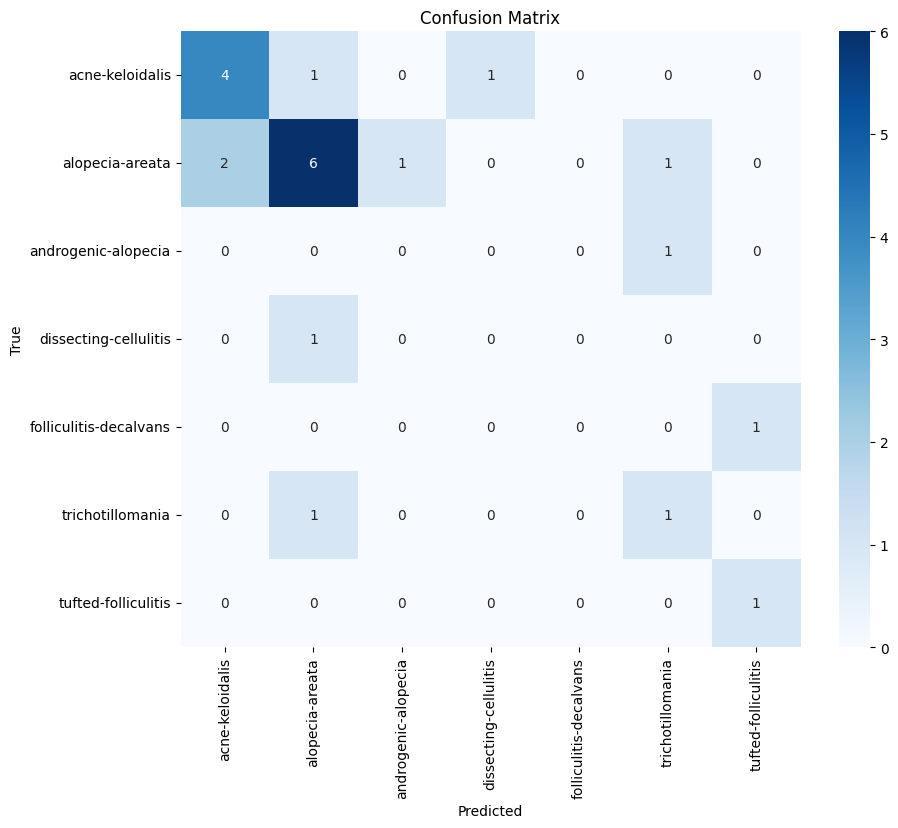

In [1]:
# Gaussian InceptionV3 - Updated for Abubakar's Local Dataset

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import os
import random
from PIL import Image
from ipywidgets import FileUpload, Button, Output
from IPython.display import display, clear_output
import io

# === PATHS ===
base_dir = r'C:\Users\Abubakar\Disease-detect\ScalpDetectAI\hairdiseasedataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# === PARAMETERS ===
img_height, img_width = 150, 150
batch_size = 32
epochs = 30

# Auto-detect number of classes
num_classes = len(os.listdir(train_dir))

# === DATA GENERATORS ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# === MODEL BUILDING ===
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# === CALLBACKS ===
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# === TRAINING ===
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping]
)

# === EVALUATION ===
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# === SAVE MODEL ===
model.save('inception_v3_finetuned_L2.h5')

# === PLOT ACCURACY/LOSS ===
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

# === CONFUSION MATRIX ===
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# class_names = list(test_generator.class_indices.keys())
# Get only the class indices that appear in test set
from collections import Counter

y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get actual class indices that exist in test data
used_class_indices = sorted(list(set(y_true)))
index_to_name = {v: k for k, v in test_generator.class_indices.items()}
class_names = [index_to_name[i] for i in used_class_indices]

# Now generate report
print("Classification Report:")
print(classification_report(y_true, y_pred, labels=used_class_indices, target_names=class_names, zero_division=1.0))

conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [2]:
# === WIDGET PREDICTOR ===
model = tf.keras.models.load_model('inception_v3_finetuned_L2.h5')
output = Output()

uploader = FileUpload(accept='image/*', multiple=False)
predict_button = Button(description='Predict')

index_to_name = {v: k for k, v in train_generator.class_indices.items()}

# def predict_image():
#     with output:
#         clear_output(wait=True)
#         if not uploader.value:
#             print("Please upload an image.")
#             return

#         content = list(uploader.value.values())[0]['content']
#         image = Image.open(io.BytesIO(content)).resize((img_width, img_height))
#         image_array = np.array(image) / 255.0
#         image_array = np.expand_dims(image_array, axis=0)

#         pred = model.predict(image_array)
#         class_idx = np.argmax(pred[0])
#         class_name = index_to_name[class_idx]

#         plt.imshow(image)
#         plt.title(f"Predicted: {class_name}")
#         plt.axis('off')
#         plt.show()

def predict_image():
    with output:
        clear_output(wait=True)
        if not uploader.value:
            print("Please upload an image.")
            return

        uploaded_file = uploader.value[0]  # <-- FIXED LINE
        content = uploaded_file['content']
        image = Image.open(io.BytesIO(content)).resize((img_width, img_height))
        image_array = np.array(image) / 255.0
        image_array = np.expand_dims(image_array, axis=0)

        pred = model.predict(image_array)
        class_idx = np.argmax(pred[0])
        class_name = index_to_name[class_idx]

        plt.imshow(image)
        plt.title(f"Predicted: {class_name}")
        plt.axis('off')
        plt.show()


predict_button.on_click(lambda b: predict_image())
display(uploader, predict_button, output)
# try:
#     get_ipython
#     from IPython.display import display
#     display(uploader, predict_button, output)
# except:
#     print("Widget prediction only works in Jupyter notebooks.")

# === OPTIONAL: Manual Prediction Function (for non-notebook environments) ===
def predict_from_path(image_path):
    image = Image.open(image_path).resize((img_width, img_height))
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    pred = model.predict(image_array)
    class_idx = np.argmax(pred[0])
    class_name = index_to_name[class_idx]
    plt.imshow(image)
    plt.title(f"Predicted: {class_name}")
    plt.axis('off')
    plt.show()
    return class_name

# === END OF SCRIPT ===
# You can now run the notebook end-to-end and use both widget or file-based prediction.
# To use file-based prediction:
# result = predict_from_path("your_image_path.jpg")
# print("Prediction:", result)


FileUpload(value=(), accept='image/*', description='Upload')

Button(description='Predict', style=ButtonStyle())

Output()